In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import re
import time

## prepare the urls

Here the URLS for all the leagues will be prepared

In [2]:
url1 = "https://www.weltfussball.de/alle_spiele/"

season = "2020-2021/"

leagues = ["bundesliga-" + season, "eng-premier-league-" + season, "esp-primera-division-" + season, 
         "ita-serie-a-" + season, "fra-ligue-1-" + season, "ned-eredivisie-" + season, 
        "aut-bundesliga-" + season, "bel-eerste-klasse-a" + season, "por-primeira-liga-" + season, "tur-sueperlig-"]

league_names = ["Bundesliga", "Premier League", "La Liga", "Serie A", "Ligue 1", "Eredivisie", "Ö Bundesliga",
        "Eerste Klasse", "Primeira Liga", "Sueperlig"]

Here you can see how the origin table looks like.

you can also check the link: https://www.weltfussball.de/alle_spiele/bundesliga-2020-2021/

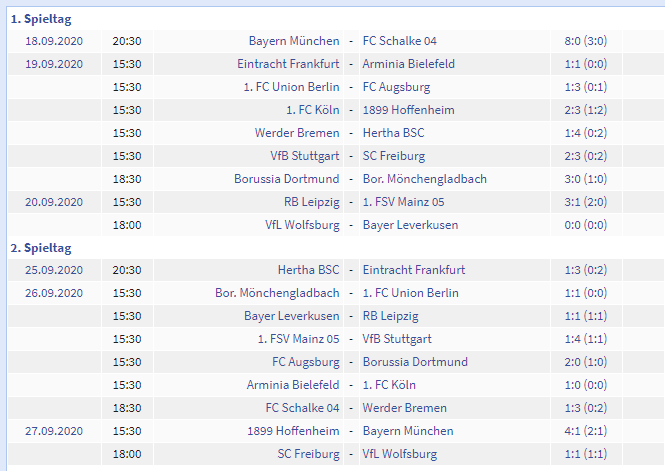

## load the data from the urls

The matches and results can be loaded directly from webpage as a DataFrame. A column for the name of the league will be added as 'Competition'. Also the column heads get adjusted for futher changes on the DF

In [3]:
all_leagues = []
j = len(leagues)
for i in range(j):
    time.sleep(1)
    url = url1+leagues[i]
    r = requests.get(url)
    df = pd.read_html(url, header = 0)
    
    df = df[1].iloc[:, :-1]
    df["Competition"] = league_names[i]
    
    # Adjusting the header
    df_header = pd.DataFrame(columns = df.columns)
    row_header = pd.Series(df.columns, index = df.columns)
    df_header = df_header.append(row_header, ignore_index=True)
    df = pd.concat([df_header, df])
    
    all_leagues.append(df)

## define the first version of the total dataframe

At this point all the DFs ( each league is one DF) get concatinated and reindexed. All NaNs are replaced by zeros and the columns get new names

In [4]:
df = pd.concat(all_leagues)
df = df.iloc[:, :-4]
df.reset_index(drop=True)
df.replace({np.nan : 0}, inplace = True)

df.rename(columns = {"1. Spieltag" : "Date", 
                 "1. Spieltag.1" : "Time", 
                 "1. Spieltag.2" : "Team Home",  
                 "1. Spieltag.3" : "vs",
                 "1. Spieltag.4" : "Team Away",
                 "1. Spieltag.5" : "Result"}, inplace = True)

## set match day and dates

To analyse the results later on, each match get its match date as well as the match day of the season

In [5]:
lst_dates = df["Date"].tolist()
lst_gameday = ['1. Spieltag']

for i in range(1, len(lst_dates)):
    val_now = lst_dates[i]
    val_before = lst_dates[i-1]
    

    if val_now == 0:
        lst_dates[i] = val_before
        lst_gameday.append(lst_gameday[-1:][0])
    elif val_now == 0 or val_now[5] == ".":
        lst_gameday.append(lst_gameday[-1:][0])
    elif val_now[4] == 'S' or val_now[3] == 'S':
        lst_gameday.append(val_now)

In this section we split the total result of each match so that each score gets an own column. the same is with the first half of the match

In [6]:
df.insert(0, 'Match Day', lst_gameday, True)
df['Date'] = lst_dates

df["Match Day"] = df['Match Day'].str.replace('. Spieltag', '').astype(int)
df['Season'] = season[:-1]
df = df[df["Result"].str[-1:] == ")"].copy()

df['Goals Home Total'] = df['Result'].apply(lambda x: x[:x.find(':')])
df['Goals Away Total'] = df['Result'].apply(lambda x: x[x.find(':') + 1 : x.find(' ')])
df["Goals Home First Half"] = df["Result"].str[-4:-3]
df["Goals Away First Half"] = df["Result"].str[-2:-1]

df = df.astype({'Goals Home Total' : int,
                'Goals Away Total' : int,
                'Goals Home First Half' : int,
                'Goals Away First Half' : int,})

df['Goals Total'] = df['Goals Home Total'] + df['Goals Away Total']

df = pd.concat([df, df], axis = 0)

Here the DF gets doubled up for the sake of the column 'Teams'.  Each match is then twice in the DF, the first time with the home team and the second time with the away team in the column 'Teams'. We need the double up to analyse how often a team is in a match with more than 2.5 goals. Also we need to check the total amount of goals of each the that participated a match

In [7]:
all_teams_home = df['Team Home'].unique().tolist()
all_teams_away = df['Team Away'].unique().tolist()
all_teams = all_teams_home + all_teams_away

lst_home = df['Team Home'].tolist()
lst_away = df['Team Away'].tolist()

div = int(len(lst_home) / 2)

lst_home = lst_home[:div]
lst_away = lst_away[:div]

lst_res = lst_home + lst_away
df.reset_index(drop = True)
df.insert(14, 'Teams', lst_res)
df['Over Goals'] = df['Goals Total'] > 2.5

In [8]:
for team in all_teams:
    print(team)

Bayern München
Eintracht Frankfurt
1. FC Union Berlin
1. FC Köln
Werder Bremen
VfB Stuttgart
Borussia Dortmund
RB Leipzig
VfL Wolfsburg
Hertha BSC
Bor. Mönchengladbach
Bayer Leverkusen
1. FSV Mainz 05
FC Augsburg
Arminia Bielefeld
FC Schalke 04
1899 Hoffenheim
SC Freiburg
Fulham FC
Crystal Palace
Liverpool FC
West Ham United
West Bromwich Albion
Tottenham Hotspur
Sheffield United
Brighton & Hove Albion
Everton FC
Leeds United
Manchester United
Arsenal FC
Southampton FC
Newcastle United
Chelsea FC
Leicester City
Aston Villa
Wolverhampton Wanderers
Burnley FC
Manchester City
SD Eibar
Granada CF
Cádiz CF
CD Alavés
Real Valladolid
Villarreal CF
Valencia CF
Getafe CF
Celta Vigo
SD Huesca
Real Betis
Real Sociedad
Elche CF
CA Osasuna
Atlético Madrid
FC Barcelona
Real Madrid
Athletic Bilbao
Sevilla FC
Levante UD
ACF Fiorentina
Parma Calcio 1913
Genoa CFC
Sassuolo Calcio
Juventus
AC Milan
Benevento Calcio
Udinese Calcio
Lazio Roma
Torino FC
Cagliari Calcio
Sampdoria
Inter
Spezia Calcio
Hellas V

In [9]:
df['Date'] = df['Date'].astype('datetime64[ns]')
df_match_day = df.groupby(['Competition']).agg(matches_played = ('Match Day', np.max))
df = pd.merge(df, df_match_day, on = 'Competition')

                                    Here you can see how the origin table was transformed


                                                            origin
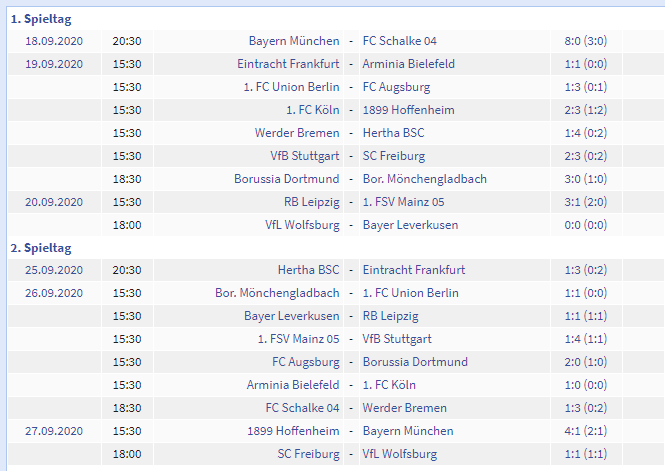


                                                          
                                                          DataFrame

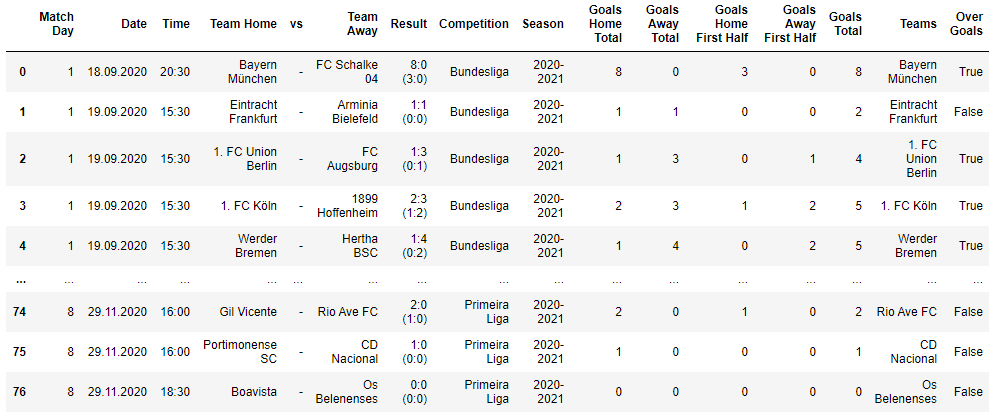

## Teams with most gotten and scored goals

In [10]:
df_most_goals = df.groupby(['Teams', 'Competition']).agg({'Goals Total' : ['sum']}).sort_values(by = ('Goals Total', 'sum'), ascending = False)

df_most_goals = df_most_goals.reset_index()
df_most_goals.columns = ['Teams', 'Competition', 'Total Goals']

df_most_goals[df_most_goals['Competition'] == 'Bundesliga'].head(5)

df = pd.merge(df, df_most_goals[['Teams','Total Goals']], on = 'Teams')

## Over Goals / more than 2.5 goals

In [11]:
df_matches_2_5 = df.groupby(['Teams']).agg(matches_2_5 = ('Over Goals', np.sum)).astype(int)
df = pd.merge(df, df_matches_2_5, on = 'Teams')

df['ratio 2.5'] = df['matches_2_5'] / df['matches_played']
df['avg goals / game'] = df['Total Goals'] / df['matches_played']
df_matches_2_5 = df.groupby(['Teams']).agg(matches_2_5 = ('Over Goals', np.sum)).astype(int)
df_matches_2_5 = df_matches_2_5.reset_index()

In [12]:
df_hitlist = df.groupby(['Competition', 'Teams', 'Total Goals', 'avg goals / game', 'matches_played', 'matches_2_5']).agg(ratio_2_5 = ('ratio 2.5', np.max)).sort_values('ratio_2_5', ascending = False).head(10)
df_list = df.groupby(['Competition', 'Teams', 'Total Goals', 'avg goals / game', 'matches_played', 'matches_2_5']).agg(ratio_2_5 = ('ratio 2.5', np.max)).sort_values('ratio_2_5', ascending = False)

df_hitlist = df_hitlist.reset_index()
df_list = df_list.reset_index()

## Results

Here you can see the table, that shows the teams with the most 3-goals-matches in a descending order by the column 'ratio_2_5 for a certain competition. Please change the competition in the cell below if you want to.

In [13]:
df_list[df_list['Competition'] == 'Bundesliga']

,Competition,Teams,Total Goals,avg goals / game,matches_played,matches_2_5,ratio_2_5
4,Bundesliga,Bayern München,52,4.727273,11,9,0.818182
16,Bundesliga,FC Schalke 04,41,3.727273,11,8,0.727273
21,Bundesliga,1899 Hoffenheim,40,3.636364,11,8,0.727273
22,Bundesliga,1. FSV Mainz 05,37,3.363636,11,8,0.727273
37,Bundesliga,1. FC Union Berlin,38,3.454545,11,7,0.636364
46,Bundesliga,Borussia Dortmund,38,3.454545,11,7,0.636364
47,Bundesliga,Hertha BSC,39,3.545455,11,7,0.636364
48,Bundesliga,VfB Stuttgart,41,3.727273,11,7,0.636364
66,Bundesliga,SC Freiburg,36,3.272727,11,6,0.545455
67,Bundesliga,RB Leipzig,32,2.909091,11,6,0.545455


Here you can see the stats for the team of your choice.

In [14]:
team = 'Ajax'

df_list[df_list['Teams'].str.contains(team) ]

,Competition,Teams,Total Goals,avg goals / game,matches_played,matches_2_5,ratio_2_5
1,Eredivisie,AFC Ajax,54,4.5,12,10,0.833333


And here are the stats for the teams with the most 3-goals-matches in Europe

In [15]:
df_hitlist

,Competition,Teams,Total Goals,avg goals / game,matches_played,matches_2_5,ratio_2_5
0,Ö Bundesliga,FC Admira Wacker,44,4.000000,11,10,0.909091
1,Eredivisie,AFC Ajax,54,4.500000,12,10,0.833333
2,Eredivisie,VVV-Venlo,54,4.500000,12,10,0.833333
3,Serie A,Sampdoria,35,3.181818,11,9,0.818182
4,Bundesliga,Bayern München,52,4.727273,11,9,0.818182
5,Serie A,Torino FC,46,4.181818,11,9,0.818182
6,Serie A,Spezia Calcio,38,3.454545,11,9,0.818182
7,Ligue 1,AS Monaco,45,3.214286,14,11,0.785714
8,Primeira Liga,Sporting CP,30,3.333333,9,7,0.777778
9,Primeira Liga,SL Benfica,32,3.555556,9,7,0.777778


In [16]:
prob = np.prod(df_hitlist['ratio_2_5'].tolist()[:4])
quote = 1.22 * 1.3 * 1.6 * 1.3 #* 1.7 * 1.65 * 1.5 * 1.6 * 1.22 * 1*7
bet = 5

In [17]:
print(prob,quote * bet)

0.5165289256198348 16.494400000000002
